In [24]:
import numpy as np
import fipy as fp
from fipy import Gmsh2D
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import os
import re
import pdb
import h5py
import pdb
import matplotlib as mpl

In [31]:
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20

In [2]:
def create_circular_mesh(radius,cellSize):
    """
    Function creates circular 2D mesh

    **Input**

    -   radius   =   Radius of mesh
    -   cellSize    =   Size of unit cell

    *Note* : No support for 3D meshes currently and **requires GMSH**
    """

    mesh = Gmsh2D('''
                     cellSize = %g;
                     radius = %g;
                     Point(1) = {0, 0, 0, cellSize};
                     Point(2) = {-radius, 0, 0, cellSize};
                     Point(3) = {0, radius, 0, cellSize};
                     Point(4) = {radius, 0, 0, cellSize};
                     Point(5) = {0, -radius, 0, cellSize};
                     Circle(6) = {2, 1, 3};


                    Circle(7) = {3, 1, 4};
                    Circle(8) = {4, 1, 5};
                    Circle(9) = {5, 1, 2};
                    Line Loop(10) = {6, 7, 8, 9};
                    Plane Surface(11) = {10};

       '''%(cellSize,radius)) # doctest: +GMSH


    return(mesh)

In [3]:
nx = 300
dx = 0.2
mesh = create_circular_mesh(radius=float(nx)*dx/2,cellSize=dx*1.5)

In [4]:
import ast

def input_parse(filename):
    """
    Parses input files (filename is path to input parameters or param_list file)

    params_flag toggles between input_params vs param_list
    """

    input_parameters  ={}
    with open(filename, 'r') as f:
        count = 0

        for line in f:
            line=line.strip()
            if line:
                if line.find('#') == -1:
                    var_name,var_value = line.split(',')[0],",".join(line.split(',')[1:]) # handle lines with more than 1 comma
                    if var_name != 'output_dir':
                        try:
                            input_parameters[var_name] = float(var_value)
                        except ValueError: # This occurs when python cannot convert list into a float.
                            # Evaluate the python expression as a list
                            input_parameters[var_name] = ast.literal_eval(var_value)
    return input_parameters

In [17]:
def generate_dynamical_trajectories(target_directory, file_name_pattern, condensate_concentration_cutoff = 0.2):

    dynamical_trajectory_file_name = 'dynamical_trajectories.hdf5'
    dynamical_variables = ['steps', 't', 'average_protein_in_condensate', 'average_lncrna_in_condensate', 
                                   'average_mrna_in_condensate', 'molar_rate_of_mrna_production', 'net_rate_of_mrna_increase', 
                                   'condensate_area', 'total_amount_of_mrna']
    
    for root, dirs, files in os.walk(target_directory):

        regex = re.compile(file_name_pattern)
        match = re.search(regex, root)

        if match != None:
            
            stats_file_name = root + '/stats.txt'
            df_stats = pd.read_csv(stats_file_name, '\t')

            times = df_stats['t']
            steps = df_stats['step']

            param_file = root + '/input_params.txt'
            input_parameters = input_parse(param_file) 

            with h5py.File(os.path.join(root + '/' + dynamical_trajectory_file_name), 'w') as dt_f:
                for dv in dynamical_variables:
                    dt_f.create_dataset(dv, shape=(len(steps),1))

            spatial_variable_hdf5_file_name = root + '/spatial_variables.hdf5'

            with h5py.File(spatial_variable_hdf5_file_name) as sp_f:      
                print(root)
                with h5py.File(os.path.join(root + '/' + dynamical_trajectory_file_name), 'a') as dt_f:

                    dt_f['steps'][:,0] = steps
                    dt_f['t'][:,0] = times
                    
                    indices_enhancer_region = (mesh.x-0.5*input_parameters['rna_nucleus_distance_to_protein'])**2 + mesh.y**2 - input_parameters['sigma']**2 < 0

                    for s in range(len(steps)):

                        phi_p = fp.CellVariable(mesh=mesh, value = sp_f['phi_p'][s])
                        phi_m = fp.CellVariable(mesh=mesh, value = sp_f['phi_m'][s])
                        phi_r = fp.CellVariable(mesh=mesh, value = sp_f['phi_r'][s])

                        indices = phi_p.value > condensate_concentration_cutoff   

                        if np.any(indices):
                            dt_f['condensate_area'][s] = np.sum(mesh.cellVolumes[indices])
                            dt_f['average_protein_in_condensate'][s] = np.sum(phi_p.value[indices]*mesh.cellVolumes[indices])/np.sum(mesh.cellVolumes[indices])
                        else:
                            dt_f['condensate_area'][s] = 0.0
                            dt_f['average_protein_in_condensate'][s] = 0.0
                        
                        # dt_f['average_protein_in_condensate'][s] = np.sum(phi_p.value[indices_enhancer_region]*mesh.cellVolumes[indices_enhancer_region])/np.sum(mesh.cellVolumes[indices_enhancer_region])
                        dt_f['average_lncrna_in_condensate'][s] = np.sum(phi_r.value[indices_enhancer_region]*mesh.cellVolumes[indices_enhancer_region])/np.sum(mesh.cellVolumes[indices_enhancer_region])
                        # dt_f['average_mrna_in_condensate'][s] = np.sum(phi_m.value[indices_enhancer_region]*mesh.cellVolumes[indices_enhancer_region])/np.sum(mesh.cellVolumes[indices_enhancer_region])
                        if dt_f['average_lncrna_in_condensate'][s] < 0.0:
                            dt_f['average_lncrna_in_condensate'][s] = 0.0
                        
                        # dt_f['total_amount_of_mrna'][s] = np.sum(phi_m.value*mesh.cellVolumes)

#                         if input_parameters['reaction_rate'] == 0.0:
#                             dt_f['molar_rate_of_mrna_production'][s] =  np.sum((input_parameters['k_p_max']*(phi_p - input_parameters['protein_threshold_mRNA_production'])*(phi_p > input_parameters['protein_threshold_mRNA_production'])).value*mesh.cellVolumes)
#                             dt_f['net_rate_of_mrna_increase'][s] =  np.sum((input_parameters['k_p_max']*(phi_p - input_parameters['protein_threshold_mRNA_production'])*(phi_p > input_parameters['protein_threshold_mRNA_production'])-input_parameters['k_degradation']*phi_m).value*mesh.cellVolumes)
#                         elif input_parameters['reaction_rate'] == 1.0:
#                             dt_f['molar_rate_of_mrna_production'][s] =  np.sum((input_parameters['k_p_max']*(phi_p > input_parameters['protein_threshold_mRNA_production'])).value*mesh.cellVolumes)
#                             dt_f['net_rate_of_mrna_increase'][s] =  np.sum((input_parameters['k_p_max']*(phi_p > input_parameters['protein_threshold_mRNA_production'])-input_parameters['k_degradation']*phi_m).value*mesh.cellVolumes)
#                         elif input_parameters['reaction_rate'] == 2.0:
#                             kpx = input_parameters['k_p_max']*np.exp(-((mesh.cellCenters[0]+0.5*input_parameters['rna_nucleus_distance_to_protein'])**2 + (mesh.cellCenters[1])**2)/input_parameters['spread_kp']**2)
#                             dt_f['molar_rate_of_mrna_production'][s] =  np.sum(kpx.value*phi_p.value*mesh.cellVolumes)
#                             dt_f['net_rate_of_mrna_increase'][s] =  np.sum((kpx*phi_p-input_parameters['k_degradation']*phi_m).value*mesh.cellVolumes)

In [18]:
directory = "/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE"
file_name_pattern = r'.*K_1.0$'

generate_dynamical_trajectories(directory, file_name_pattern, condensate_concentration_cutoff = 0.4)

/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_5.0_L_P_6.0_K_1.0
/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_25.0_L_P_3.0_K_1.0
/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_25.0_L_P_12.0_K_1.0
/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_10.0_L_P_7.0_K_1.0
/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_15.0_L_P_7.0_K_1.0
/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_10.0_L_P_3.0_K_1.0
/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_5.0_L_P_7.0_K_1.0
/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_15.0_L_P_15.0_K_1.0
/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_25.0_L_P_10.0_K_1.0


### Generate plots

/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_5.0_L_P_3.0_K_1.0
/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_5.0_L_P_7.0_K_1.0
/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_5.0_L_P_12.0_K_1.0


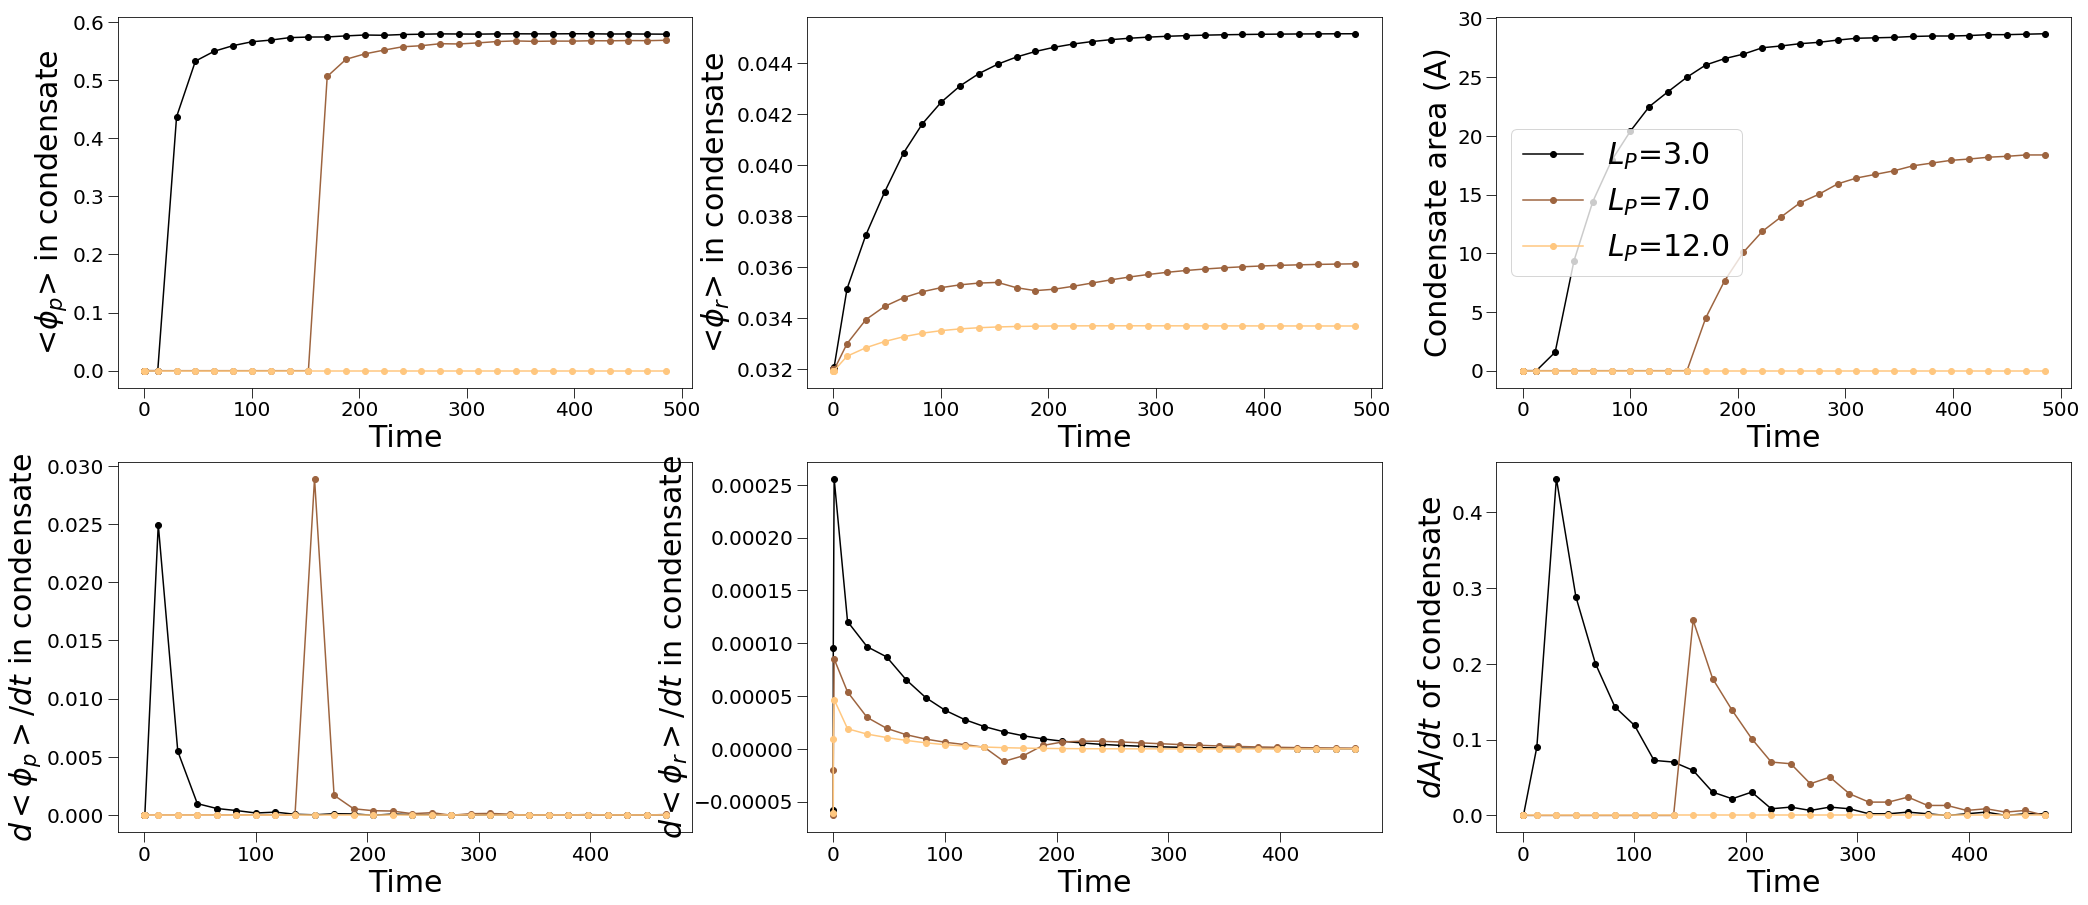

/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_10.0_L_P_3.0_K_1.0
/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_10.0_L_P_7.0_K_1.0
/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_10.0_L_P_12.0_K_1.0


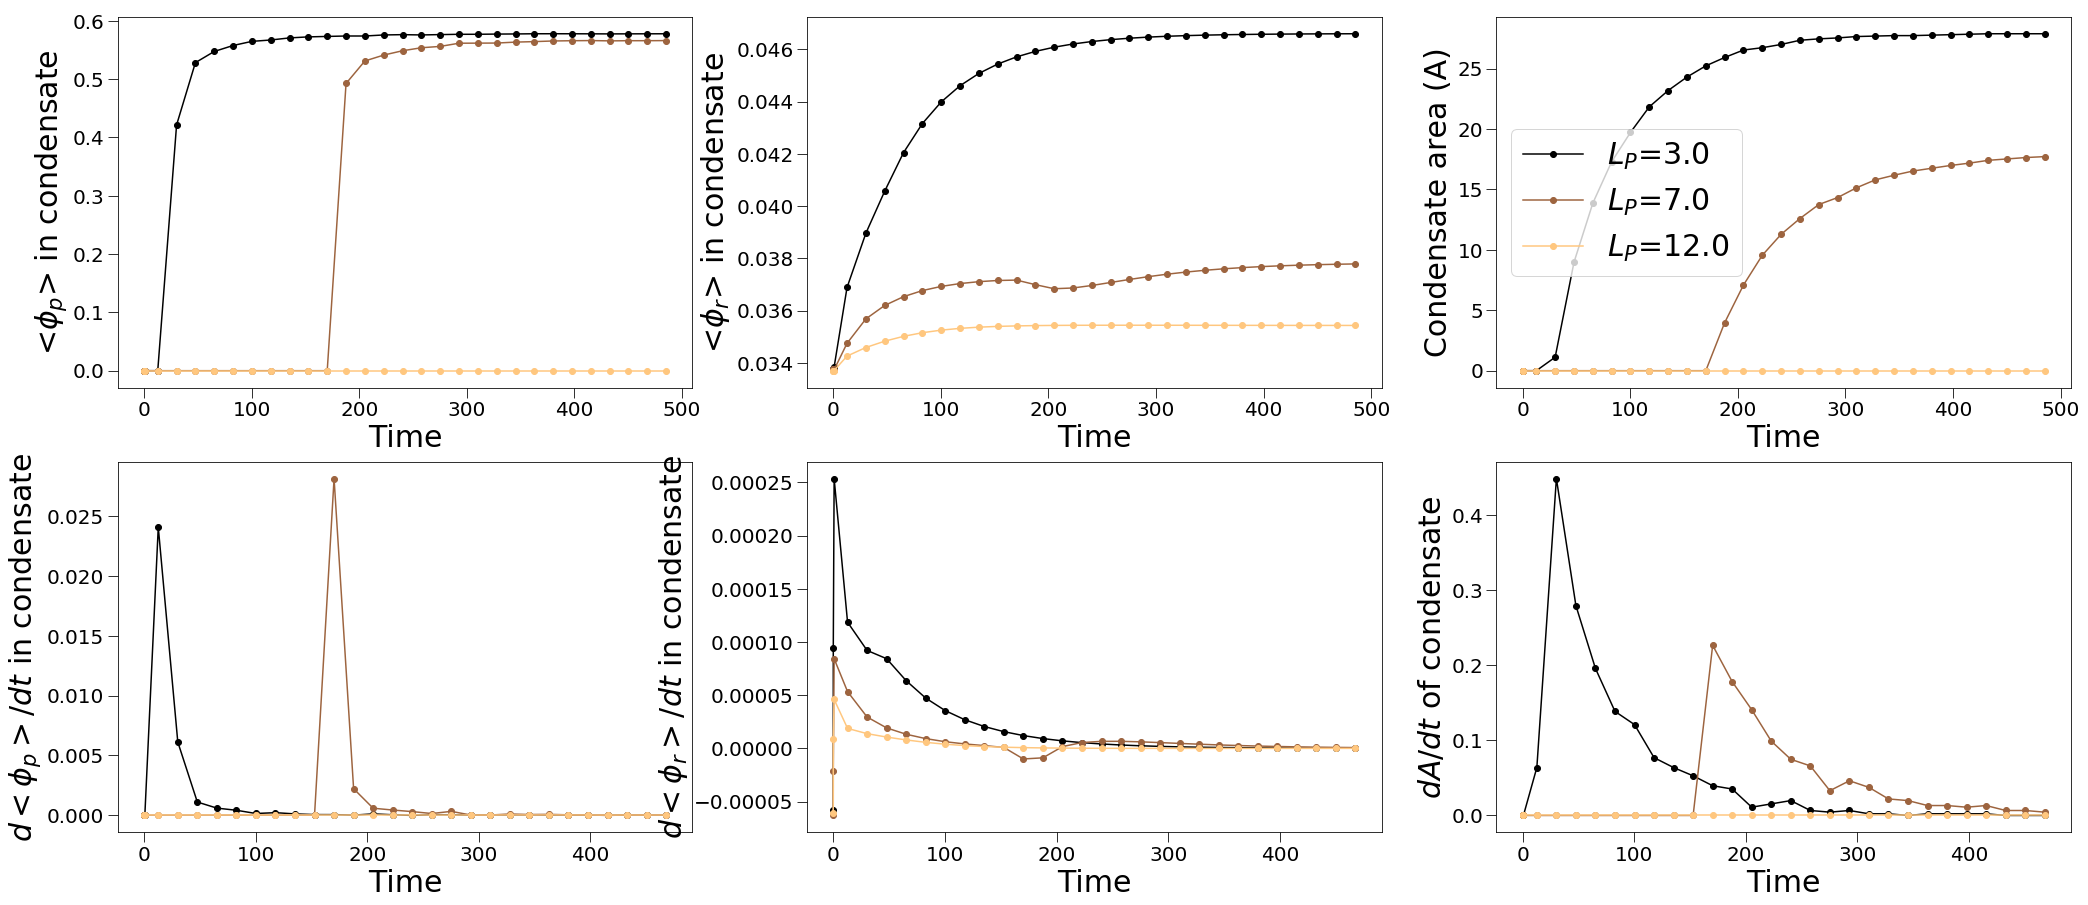

/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_15.0_L_P_3.0_K_1.0
/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_15.0_L_P_7.0_K_1.0
/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_15.0_L_P_12.0_K_1.0


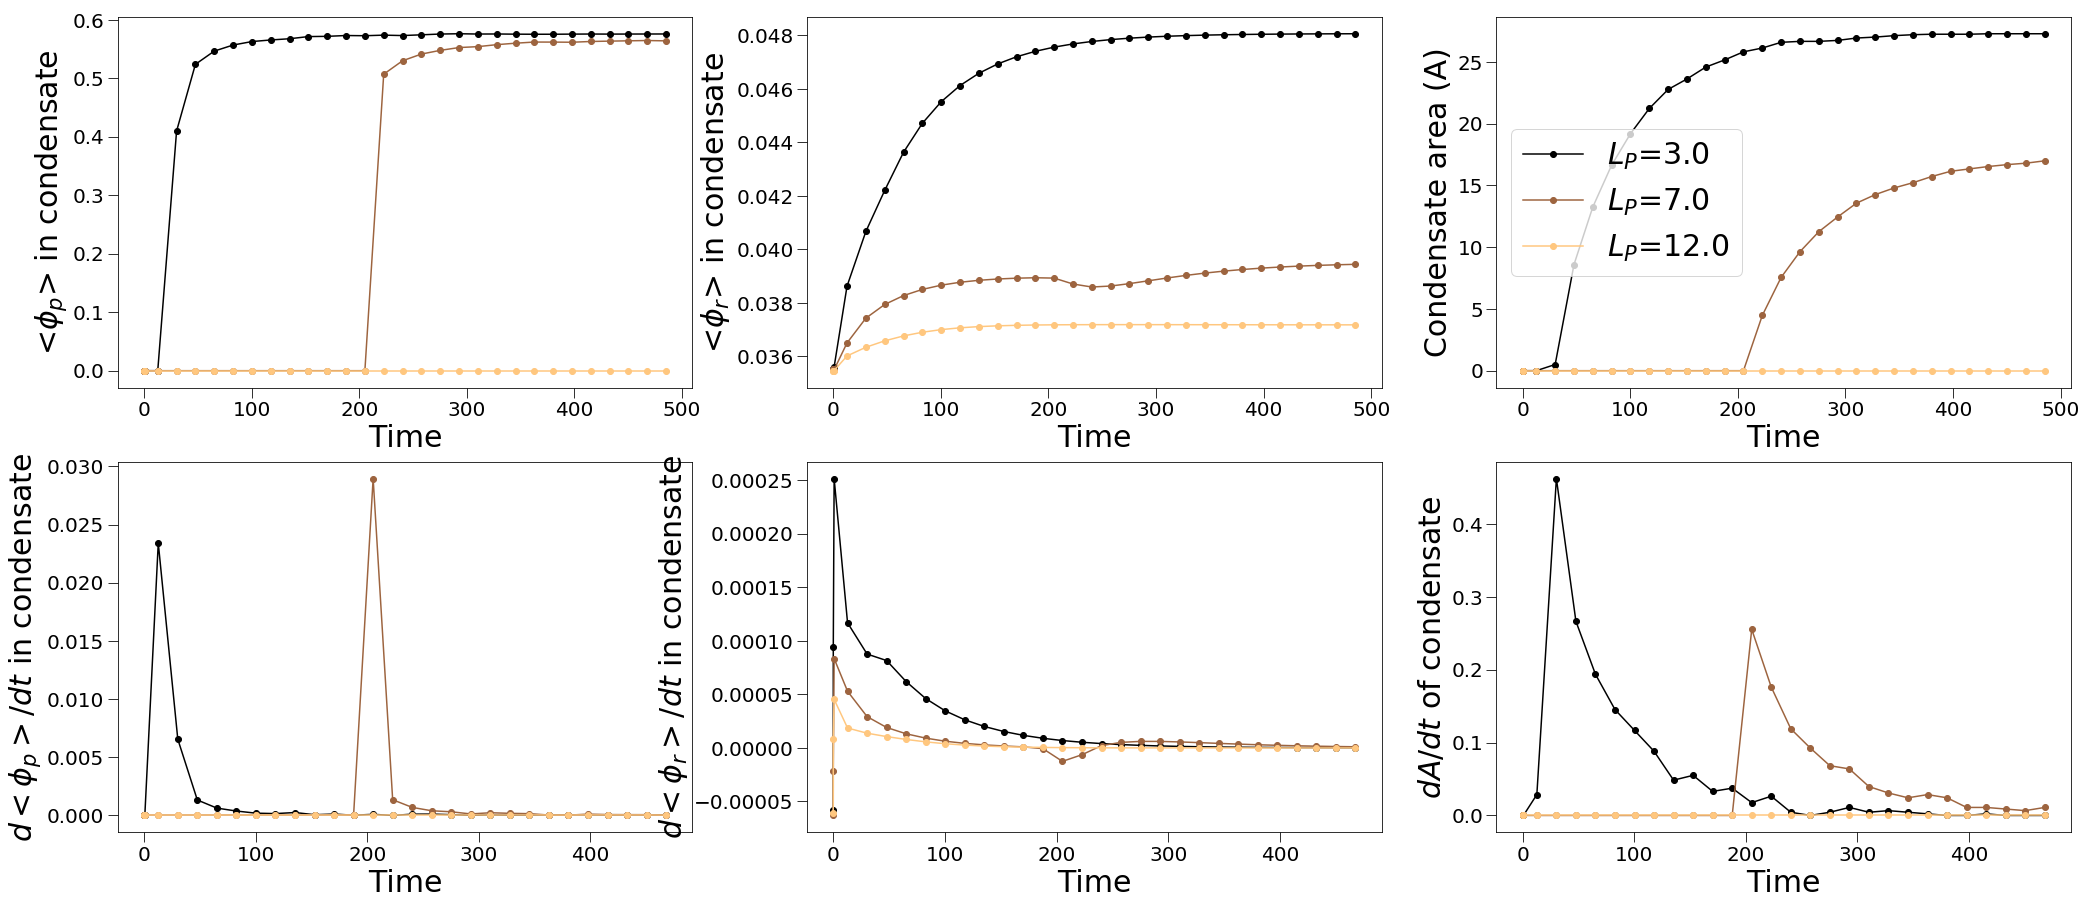

/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_20.0_L_P_3.0_K_1.0
/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_20.0_L_P_7.0_K_1.0
/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/phi_r_20.0_L_P_12.0_K_1.0


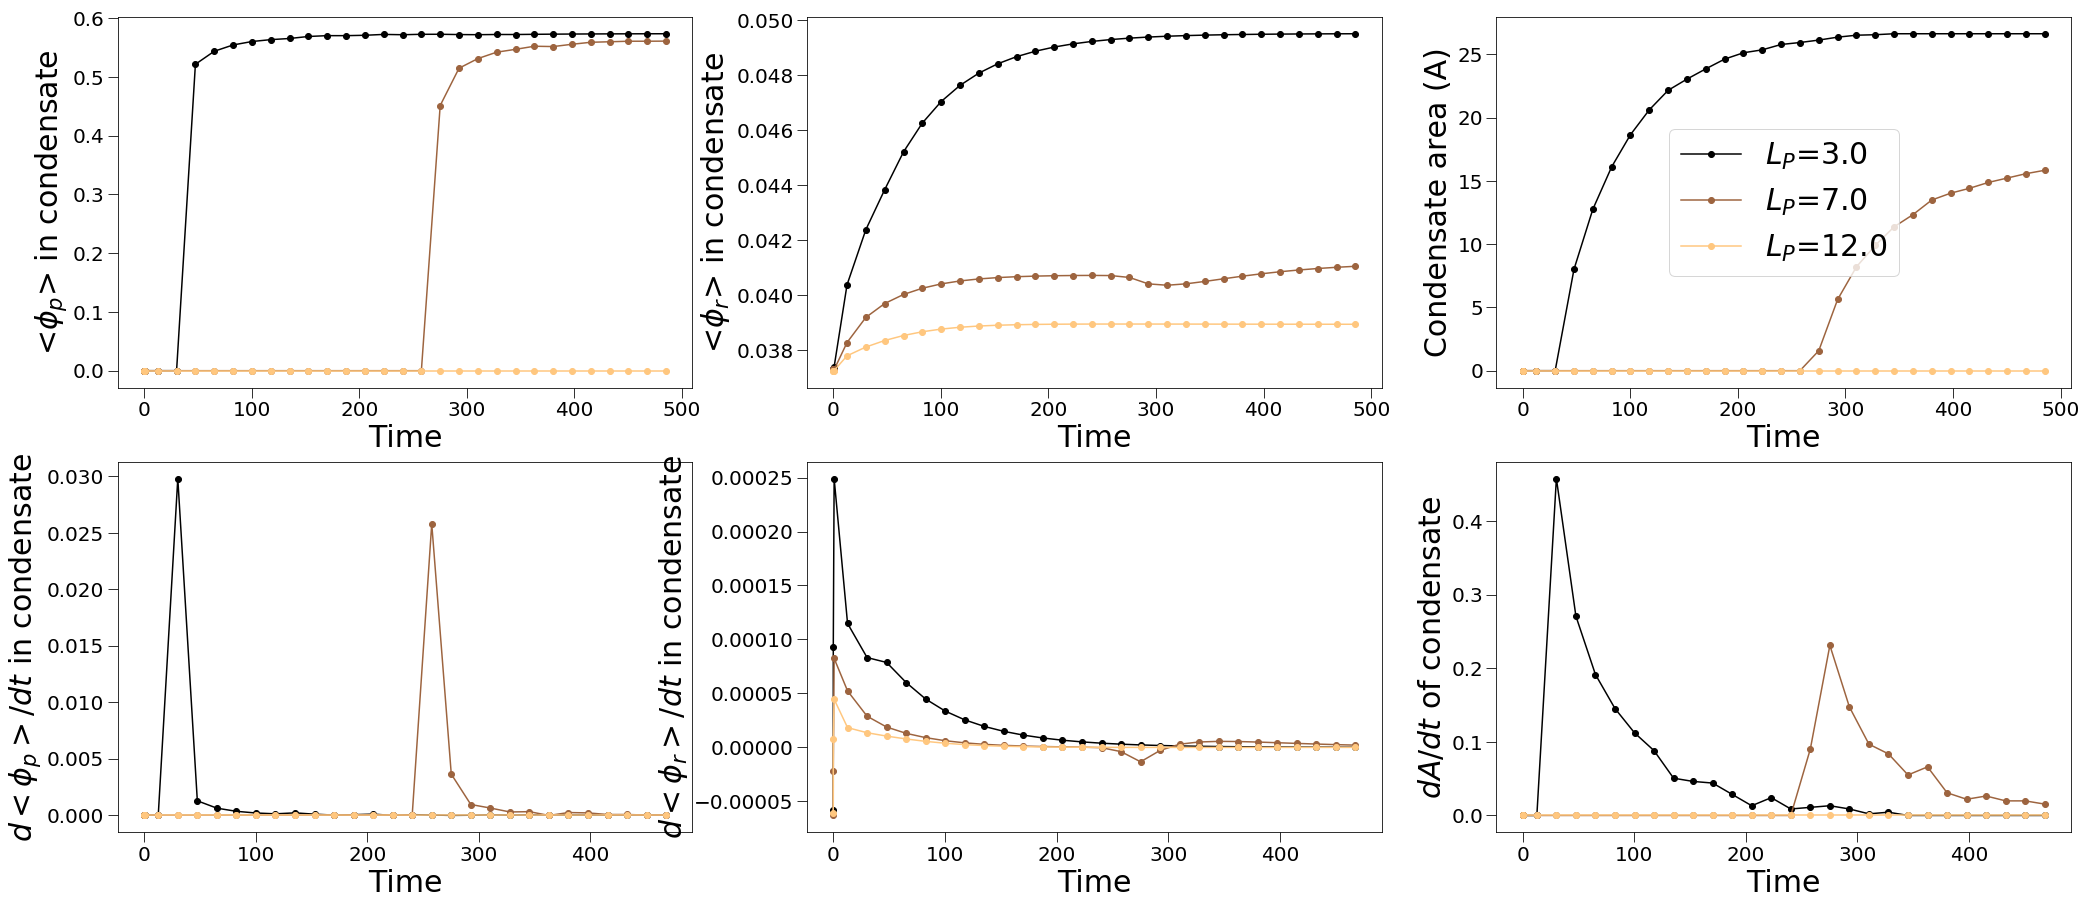

In [34]:
activity_and_lncrna_directory = "/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/"

kp_list = [1.0]
L_P_list = [3.0,7.0,12.0]
phi_r_list = [5.0,10.0,15.0,20.0]

gray_colors = cm.get_cmap('copper', len(L_P_list))
color_values = np.linspace(0.0,1,len(L_P_list))

for i in range(len(phi_r_list)):
    for j in range(len(kp_list)):
        
        fig, axs = plt.subplots(2,3,figsize=(35,15))

        for k in range(len(L_P_list)):
            for root, dirs, files in os.walk(activity_and_lncrna_directory):
                regex = re.compile(r'.*phi_r_{}_.*L_P_{}_K_{}$'.format(phi_r_list[i],L_P_list[k],kp_list[j]))
                match = re.search(regex, root)
                if match != None:
                    with h5py.File(root + '/dynamical_trajectories.hdf5') as sp_f: 
                        
                        print(root)

                        axs[0,0].plot(sp_f['t'],sp_f['average_protein_in_condensate'], '-o', c=gray_colors(color_values[k]))
                        axs[0,0].set_xlabel('Time', fontsize=30)
                        axs[0,0].set_ylabel(r'<$\phi_p$> in condensate', fontsize=30)
                        # axs[0,0].set_ylim([0.4,0.7])

                        axs[0,1].plot(sp_f['t'],sp_f['average_lncrna_in_condensate'], '-o', c=gray_colors(color_values[k]))
                        axs[0,1].set_xlabel('Time', fontsize=30)
                        axs[0,1].set_ylabel(r'<$\phi_r$> in condensate', fontsize=30)
                        
#                         axs[0,2].plot(sp_f['t'],sp_f['average_mrna_in_condensate'], '-o', c=gray_colors(color_values[k]))
#                         axs[0,2].set_xlabel('Time', fontsize=20)
#                         axs[0,2].set_ylabel(r'<$\phi_m$> in condensate', fontsize=20)
                        
#                         axs[0,3].plot(sp_f['t'],sp_f['total_amount_of_mrna'], '-o', c=gray_colors(color_values[k]))
#                         axs[0,3].set_xlabel('Time', fontsize=20)
#                         axs[0,3].set_ylabel(r'Amount of mRNA in system', fontsize=20)
                        
                        axs[0,2].plot(sp_f['t'],sp_f['condensate_area'], '-o', c=gray_colors(color_values[k]), label="$L_P$="+str(L_P_list[k]))
                        axs[0,2].set_xlabel('Time', fontsize=30)
                        axs[0,2].set_ylabel(r'Condensate area (A)', fontsize=30)
                        axs[0,2].legend(fontsize=30) 
                        
                        p_conc_growth_rate = (sp_f['average_protein_in_condensate'][1:]-sp_f['average_protein_in_condensate'][:-1])*(sp_f['t'][1:]-sp_f['t'][:-1])**(-1)
                        p_conc_growth_rate[p_conc_growth_rate > 0.05] = 0.0
                        axs[1,0].plot(sp_f['t'][:-1], p_conc_growth_rate, '-o', c=gray_colors(color_values[k]))
                        axs[1,0].set_xlabel('Time', fontsize=30)
                        axs[1,0].set_ylabel(r'$d<\phi_p>/dt$ in condensate', fontsize=30)
                        
                        l_conc_growth_rate = (sp_f['average_lncrna_in_condensate'][1:]-sp_f['average_lncrna_in_condensate'][:-1])*(sp_f['t'][1:]-sp_f['t'][:-1])**(-1)
                        # p_conc_growth_rate[conc_growth_rate > 0.02] = 0.0
                        axs[1,1].plot(sp_f['t'][:-1], l_conc_growth_rate, '-o', c=gray_colors(color_values[k]))
                        axs[1,1].set_xlabel('Time', fontsize=30)
                        axs[1,1].set_ylabel(r'$d<\phi_r>/dt$ in condensate', fontsize=30)
                        
#                         axs[1,2].plot(sp_f['t'],sp_f['molar_rate_of_mrna_production'], '-o', c=gray_colors(color_values[k]))
#                         axs[1,2].set_xlabel('Time', fontsize=20)
#                         axs[1,2].set_ylabel(r'Molar production rate of mRNA', fontsize=20)

#                         axs[1,3].plot(sp_f['t'],sp_f['net_rate_of_mrna_increase'], '-o', c=gray_colors(color_values[k]), label="$L_P$="+str(L_P_list[k]))
#                         axs[1,3].set_xlabel('Time', fontsize=20)
#                         axs[1,3].set_ylabel(r'Net molar rate of change of mRNA', fontsize=20)  
#                         axs[1,3].legend(fontsize=20) 

                        area_growth_rate = (sp_f['condensate_area'][1:]-sp_f['condensate_area'][:-1])*(sp_f['t'][1:]-sp_f['t'][:-1])**(-1)
                        axs[1,2].plot(sp_f['t'][:-1], area_growth_rate, '-o', c=gray_colors(color_values[k]))
                        axs[1,2].set_xlabel('Time', fontsize=30)
                        axs[1,2].set_ylabel(r'$dA/dt$ of condensate', fontsize=30)

        # plt.savefig('20210604-CORRECT_FE/Only_activity_linear_0.4_dynamical_trajectories.png', format='png', dpi=1200)
        plt.savefig('20210719-CORRECT_FE_ONLY_LNCRNA/lncrna_only_0_K_{}_phir_{}_dynamical_trajectories.svg'.format(kp_list[j],phi_r_list[i]), format='svg', dpi=1200)
        plt.show()
        plt.close()

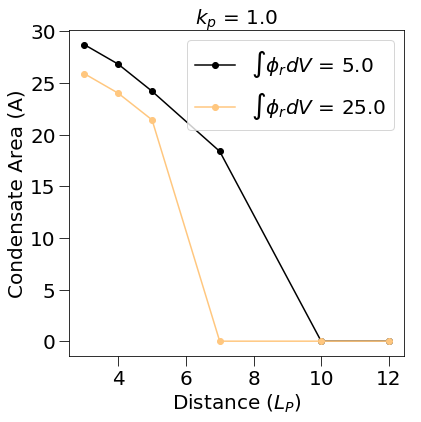

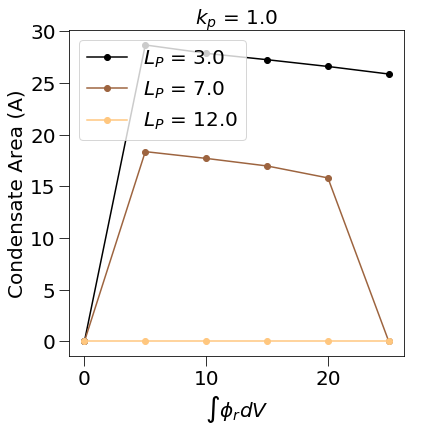

In [43]:
activity_and_lncrna_directory = "/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/"

kp_list = [1.0]
L_P_list = [3.0,4.0,5.0,7.0,10.0,12.0]
phi_r_list = [5.0, 25.0]

#################################

dynamical_variable_name = 'condensate_area'
gray_colors = cm.get_cmap('copper', len(phi_r_list))
color_values = np.linspace(0.3,0.9,len(phi_r_list))

fig, axs = plt.subplots(1,1,figsize=(6,6))
for i in range(len(kp_list)):
    for k in range(len(phi_r_list)):
        ss_values = np.zeros(len(L_P_list))
        for j in range(len(L_P_list)):
            for root, dirs, files in os.walk(activity_and_lncrna_directory):
                regex = re.compile(r'.*phi_r_{}_.*L_P_{}_K_{}$'.format(phi_r_list[k],L_P_list[j],kp_list[i]))
                match = re.search(regex, root)
                if match != None:
                    with h5py.File(root + '/dynamical_trajectories.hdf5') as sp_f: 
                        ss_values[j] = sp_f[dynamical_variable_name][-1]
        axs.plot(L_P_list, ss_values, '-o', label='$\int\phi_rdV$ = '+str(phi_r_list[k]), c=gray_colors(color_values[k]))
    axs.set_xlabel('Distance ($L_P$)',fontsize=20)
    axs.set_ylabel('Condensate Area (A)',fontsize=20)
    axs.set_title(r'$k_p$ = ' + str(kp_list[i]), fontsize=20)
    axs.legend(fontsize=20)

plt.savefig('20210719-CORRECT_FE_ONLY_LNCRNA/lncrna_steady_state_vs_LP_'+dynamical_variable_name+'.svg', format='svg', dpi=1200)
plt.show()
plt.close()

L_P_list = [3.0,7.0,12.0]
phi_r_list = [0.0,5.0,10.0,15.0,20.0,25.0]

dynamical_variable_name = 'condensate_area'
gray_colors = cm.get_cmap('copper', len(L_P_list))
color_values = np.linspace(0.2,1,len(L_P_list))

fig, axs = plt.subplots(1,len(kp_list),figsize=(6,6))
for i in range(len(kp_list)):
    for j in range(len(L_P_list)):
        ss_values = np.zeros(len(phi_r_list))
        for k in range(len(phi_r_list)):
            for root, dirs, files in os.walk(activity_and_lncrna_directory):
                regex = re.compile(r'.*phi_r_{}_.*L_P_{}_K_{}$'.format(phi_r_list[k],L_P_list[j],kp_list[i]))
                match = re.search(regex, root)
                if match != None:
                    with h5py.File(root + '/dynamical_trajectories.hdf5') as sp_f: 
                        ss_values[k] = sp_f[dynamical_variable_name][-1]
        axs.plot(phi_r_list, ss_values, '-o', label=r'$L_P$ = '+str(L_P_list[j]), c=gray_colors(color_values[j]))
    axs.set_xlabel('$\int\phi_rdV$',fontsize=20)
    axs.set_ylabel('Condensate Area (A)',fontsize=20)
    axs.set_title(r'$k_p$ = ' + str(kp_list[i]), fontsize=20)
    axs.legend(fontsize=20)

plt.savefig('20210719-CORRECT_FE_ONLY_LNCRNA/lncrna_steady_state_vs_phir_'+dynamical_variable_name+'.svg', format='svg', dpi=1200)
plt.show()
plt.close()

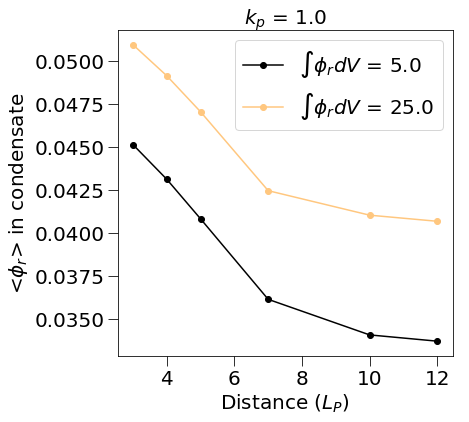

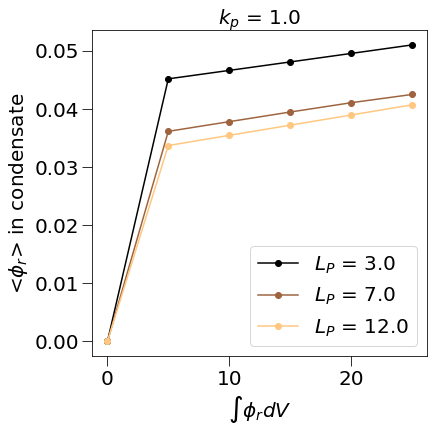

In [46]:
activity_and_lncrna_directory = "/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/"

kp_list = [1.0]
L_P_list = [3.0,4.0,5.0,7.0,10.0,12.0]
phi_r_list = [5.0, 25.0]

#################################

dynamical_variable_name = 'average_lncrna_in_condensate'
gray_colors = cm.get_cmap('copper', len(phi_r_list))
color_values = np.linspace(0.3,0.9,len(phi_r_list))

fig, axs = plt.subplots(1,1,figsize=(6,6))
for i in range(len(kp_list)):
    for k in range(len(phi_r_list)):
        ss_values = np.zeros(len(L_P_list))
        for j in range(len(L_P_list)):
            for root, dirs, files in os.walk(activity_and_lncrna_directory):
                regex = re.compile(r'.*phi_r_{}_.*L_P_{}_K_{}$'.format(phi_r_list[k],L_P_list[j],kp_list[i]))
                match = re.search(regex, root)
                if match != None:
                    with h5py.File(root + '/dynamical_trajectories.hdf5') as sp_f: 
                        ss_values[j] = sp_f[dynamical_variable_name][-1]
        axs.plot(L_P_list, ss_values, '-o', label='$\int\phi_rdV$ = '+str(phi_r_list[k]), c=gray_colors(color_values[k]))
    axs.set_xlabel('Distance ($L_P$)',fontsize=20)
    axs.set_ylabel(r'<$\phi_r$> in condensate',fontsize=20)
    axs.set_title(r'$k_p$ = ' + str(kp_list[i]), fontsize=20)
    axs.legend(fontsize=20)

plt.savefig('20210719-CORRECT_FE_ONLY_LNCRNA/lncrna_steady_state_vs_LP_'+dynamical_variable_name+'.svg', format='svg', dpi=1200)
plt.show()
plt.close()

L_P_list = [3.0,7.0,12.0]
phi_r_list = [0.0,5.0,10.0,15.0,20.0,25.0]

dynamical_variable_name = 'average_lncrna_in_condensate'
gray_colors = cm.get_cmap('copper', len(L_P_list))
color_values = np.linspace(0.2,1,len(L_P_list))

fig, axs = plt.subplots(1,len(kp_list),figsize=(6,6))
for i in range(len(kp_list)):
    for j in range(len(L_P_list)):
        ss_values = np.zeros(len(phi_r_list))
        for k in range(len(phi_r_list)):
            for root, dirs, files in os.walk(activity_and_lncrna_directory):
                regex = re.compile(r'.*phi_r_{}_.*L_P_{}_K_{}$'.format(phi_r_list[k],L_P_list[j],kp_list[i]))
                match = re.search(regex, root)
                if match != None:
                    with h5py.File(root + '/dynamical_trajectories.hdf5') as sp_f: 
                        ss_values[k] = sp_f[dynamical_variable_name][-1]
        axs.plot(phi_r_list, ss_values, '-o', label=r'$L_P$ = '+str(L_P_list[j]), c=gray_colors(color_values[j]))
    axs.set_xlabel('$\int\phi_rdV$',fontsize=20)
    axs.set_ylabel(r'<$\phi_r$> in condensate',fontsize=20)
    axs.set_title(r'$k_p$ = ' + str(kp_list[i]), fontsize=20)
    axs.legend(fontsize=20)

plt.savefig('20210719-CORRECT_FE_ONLY_LNCRNA/lncrna_steady_state_vs_phir_'+dynamical_variable_name+'.svg', format='svg', dpi=1200)
plt.show()
plt.close()